### Pipeline for a single spikeglx session
- Load saved, synched extractors (spikeinterface)
- Load spikes
- lod bout_dict

- make a visualization of a bout
- make a visualization of the neural data (spikes)

- make projectios using umap

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-09-14 15:37:20,935 root         INFO     all modules loaded


In [4]:
si

<module 'spikeinterface' from '/home/earneodo/anaconda3/lib/python3.8/site-packages/spikeinterface/__init__.py'>

In [5]:
### Session parameters and raw files

In [6]:
reload(et)

bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [7]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [8]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx'

In [9]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-09-14 15:37:21,523 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/stream.kwd', 'kwik': '/scratch/earneodo/s_b1253_21/sgl

['0712_g0', '1255_g0', '1740_g0', '2118_g0']

In [10]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [11]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0'}

In [12]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.ap.meta']}

In [13]:
files_pd = pd.DataFrame(sgl_files)

In [14]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...


#### load the recordings

In [22]:
### so as to just load them here

mic_chan_id = [0] # this should come from reading the metatada
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

### this will make new recordings. The good way to go is to save the synced recordings asp pickles earlier
run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}
## get all effective sampling rates
[i.get_effective_sf() for i in run_recordings.values()]

mic_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)

2021-09-14 15:40:56,265 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-09-14 15:41:21,898 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-09-14 15:41:21,899 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-09-14 15:41:21,900 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (51463406,)
2021-09-14 15:44:18,825 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.0016477727883
2021-09-14 15:44:19,836 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-09-14 15:44:19,838 ceciestun

### load the bout and spike data
- TODO: save extractor pickle files in the sglx_pipe-dev-sort-bouts
- Load the bout pkl file (already synched to spikes)
- Load the spikes 

In [23]:
# load the bouts file
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict.pkl')

with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
    
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.729158569764,
 's_f_ap_0': 30000.08851535173,
 'start_ms': array([   15670,    64840,   111021,   179462,   283673,   369585,
          412455,   463166,  1327117,  1375918,  1422939,  1476920,
         1512150,  1585791,  1625022,  1909165,  1970426,  2019337,
         2653635,  2767537,  3010220,  3130512,  3213943,  3274544,
         3331045,  3383875,  3447146,  3849752,  3878442,  3919723,
         3973943,  4028434,  4136056,  4227237,  4321558,  4994037,
         5110359,  5263871,  5439493,  5560425,  6411036,  6718590,
         6771761, 16331021, 16385721, 17007670, 17237233, 17388535]),
 'len_ms': array([37010, 29740, 35610, 37030, 29450, 28370, 33170, 28940, 34000,
        32720, 34080, 24200, 27210, 25860, 25790, 40590, 34500, 37290,
        32000, 48920, 31970, 51390, 30640, 30680, 33000, 29870, 29200,
        27420, 20510, 32030, 31910, 35040, 44200, 42770,

In [17]:
### load the spikes from pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df = pd.read_pickle(spike_pickle_path)
clu_df = pd.read_pickle(clu_pickle_path)

spk_df.head(3)

,times,clusters,nucelus,main_chan,kslabel
0,104,64,ra,78,good
1,120,21,ra,27,good
2,139,72,ra,90,good


In [18]:
## plot some example waveform

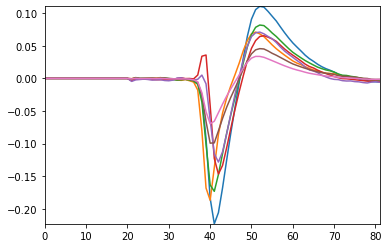

In [19]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

# Plot spikes/audio

In [20]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [21]:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)

def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

### collect one bout

<ipython-input-110-4ae64c4af705>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


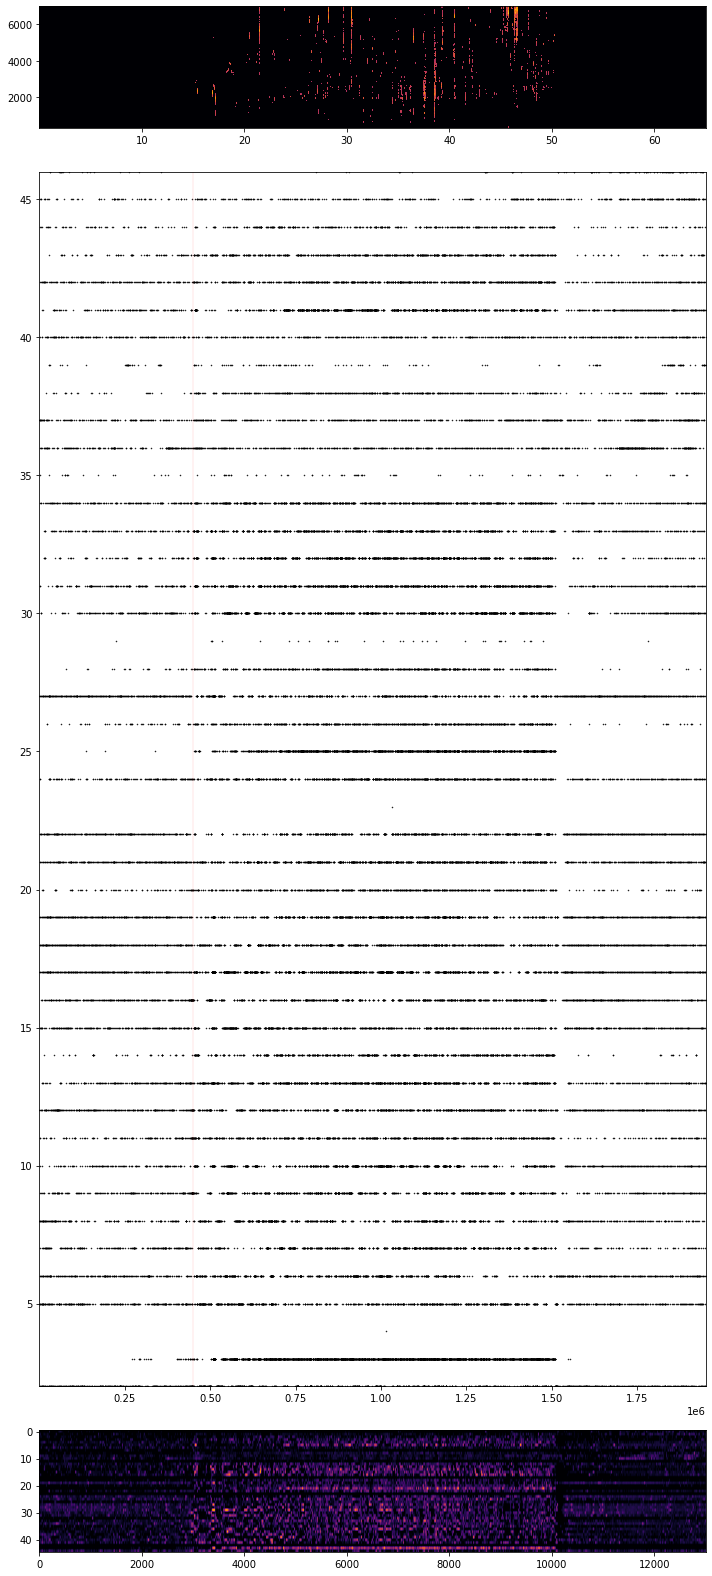

In [110]:
#### what to plot
## make a list of clusters that is just the 'good' units as per KS auto label
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15


##Pick a bout
bout_idx = 2

def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

    start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
    end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream[0, start_nidq: end_nidq]
    
    return spk_arr, mic_arr

spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list)


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_nidq)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[1])

bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
rates_arr = pu.coarse(spk_arr, bin_size_sample)
rates_arr[np.isnan(rates_arr)] = 0

#psth = np.nansum(rates_arr, axis=0)
#ax[2].plot(psth);
ax[2].imshow(rates_arr[::-1], aspect='auto', cmap='inferno')

plt.tight_layout()

### collect all bouts

In [128]:
spk_arr_list = []
mic_arr_list = []

t_pre = 5
t_post = 5

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list)
    spk_arr_list.append(spk_arr)
    mic_arr_list.append(mic_arr)
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[473, 447, 466, 489, 520, 563, 660, 658, 612, ..."
1,1296784,1945211,29739,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-392, -358, -457, -458, -324, -196, -215, -35..."
2,2220373,3330616,35610,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2222, 2264, 2269, 2348, 2311, 2174, 2123, 213..."
3,3589156,5383825,37030,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1104, 1124, 1142, 1145, 1136, 1118, 1134, 113..."
4,5673330,8510137,29449,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-988, -983, -986, -1009, -1022, -1018, -1007,..."


### get spectrograms and rate-grams

In [133]:
f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_nidq)


bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_nidq))

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [141]:
bin_size_ms = 1
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )

rates_arr = pu.coarse(spk_arr, bin_size_sample)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

In [142]:
bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx,fr_arr,sxx_all
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[473, 447, 466, 489, 520, 563, 660, 658, 612, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([312.49576810265256, 351.55773911548414, 390...."
1,1296784,1945211,29739,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-392, -358, -457, -458, -324, -196, -215, -35...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.03333333333333333, 0.0, 0.0, 0.0, 0.0...","([312.49576810265256, 351.55773911548414, 390...."
2,2220373,3330616,35610,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2222, 2264, 2269, 2348, 2311, 2174, 2123, 213...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0...","([312.49576810265256, 351.55773911548414, 390...."
3,3589156,5383825,37030,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1104, 1124, 1142, 1145, 1136, 1118, 1134, 113...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([312.49576810265256, 351.55773911548414, 390...."
4,5673330,8510137,29449,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-988, -983, -986, -1009, -1022, -1018, -1007,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033333333333...","([312.49576810265256, 351.55773911548414, 390...."


## make the rollings

##### try one umap embeddin

In [147]:
import umap

ModuleNotFoundError: No module named 'umap'

In [146]:
from ceciestunepipe.util.dimension import umapred as dim

ModuleNotFoundError: No module named 'umap'

In [ ]:
umap_win = 20
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

In [107]:
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     